In [1]:
%matplotlib inline


import numpy as np

import xarray as xr

#import regionmask 

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy.ma as ma
import csv
import netCDF4 as nc
import scipy
import pandas
from glob import glob
import pandas as pd

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [2]:
# WILL USE THESE UNITS FOR CONVERSIONS LATER, INITIALIZE HERE
R=8.317 #J/(mol K)
MW=200.59 #molecular weight of hg in g/mol
ppt=1e-12 #current [Hg0] units is ex. .03 ppt, where ppt is 1e-12
stdpressure=101325 #pascals
stdtemp=273.15 #Kelvins

In [42]:
def fix_ds(ds):
    return ds.assign_coords({'LON':ds.LON, 'LAT':ds.LAT, 'ETAC':ds.ETAC, 'ETAE':ds.ETAE, 
                            'time':pd.to_datetime(ds.attrs['Start_Date'], format='%Y%m%d')}
                           ).expand_dims('time')

#open base files (with artisnal mining)
ds_base=xr.open_mfdataset('/net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/BASE/netcdf_output/trac.2015*.nc',
                         preprocess=fix_ds,  combine='nested') #concat_dim=['time'],
#open asgm files (without artisnal mining)
ds_asgm=xr.open_mfdataset('/net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/ASGM/netcdf_output/trac.2015*.nc',
                         preprocess=fix_ds, combine='nested')
ds_asgm

KeyboardInterrupt: 

In [35]:
myasgmxr=ds_asgm['IJ-AVG-S__Hg0']*ppt* stdpressure/(stdtemp*R)*MW*1e9 
myasgmxr

<xarray.DataArray 'IJ-AVG-S__Hg0' (time: 12, Alt-002: 47, Lat-000: 91, Lon-000: 144)>
dask.array<mul, shape=(12, 47, 91, 144), dtype=float64, chunksize=(1, 47, 91, 144), chunktype=numpy.ndarray>
Coordinates:
    LON      (Lon-000) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    LAT      (Lat-000) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    ETAC     (Alt-002) float32 dask.array<chunksize=(47,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2015-12-01
Dimensions without coordinates: Alt-002, Lat-000, Lon-000

(array([2.29219e+05, 1.35345e+05, 2.29382e+05, 2.08770e+04, 7.17000e+02,
        2.83000e+02, 4.70000e+01, 1.00000e+01, 5.00000e+00, 3.00000e+00]),
 array([1.7848003e-04, 4.6146635e-02, 9.2114791e-02, 1.3808295e-01,
        1.8405110e-01, 2.3001926e-01, 2.7598742e-01, 3.2195556e-01,
        3.6792371e-01, 4.1389188e-01, 4.5986003e-01], dtype=float32),
 <BarContainer object of 10 artists>)

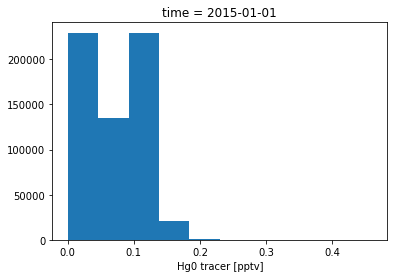

In [37]:
ds_asgm['IJ-AVG-S__Hg0'].isel(time=0).plot()

AttributeError: 'Rectangle' object has no property 'levels'

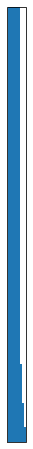

In [33]:
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

myasgmxr.mean(dim='time').plot(ax=ax, #set the axis
                        levels = np.arange(0, .5, .01), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':ds_a['IJ-AVG-S_Hg0'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                        cmap='hsv')  #choose color for our colorbar

ax.coastlines() #add coastlines
plt.title('Monthly Averaged Hg0 Difference (Artisinal Mining - No Artisinal Mining)', fontsize = 16); #title
av=df_d.resample('AS').mean()
print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

In [ ]:
ds_b=xr.Dataset()
ds_b['IJ-AVG-S_Hg0']=(ds_base['IJ-AVG-S__Hg0'])
df_base = ds_b.to_dataframe()
df_Bsurf=df_base[:157248]

In [6]:
#create shortened dataset for ds_base
ds_b=xr.Dataset()
ds_b['IJ-AVG-S_Hg0']=(ds_base['IJ-AVG-S__Hg0'])
ds_b['IJ-AVG-S_HgP']=(ds_base['IJ-AVG-S__HgP'])
ds_b['IJ-AVG-S_Hg2']=(ds_base['IJ-AVG-S__Hg2'])
ds_b['BXHGHT-S_BXHEIGHT']=(ds_base['BXHGHT-S__BXHEIGHT'])
ds_b['BXHGHT-S_T']=(ds_base['BXHGHT-S__T']) #Kelvins
ds_b['BXHGHT-S_PMID']=(ds_base['BXHGHT-S__PMID'])*100 #hpa to pa
ds_b['BXHGHT-S_PMID'].attrs['unit']='Pa'

df_base = ds_b.to_dataframe()
df_Bsurf=df_base[:157248]

# #######changing units to ng/m3 from ppt using P/(TR)*pptv*MW #########

'''P/(TR)*ppt*MW --> Pa/(K*J/(mol*K))*ppt*g/mol --> g/m3*ppt. to get rid of ppt, multiply by 1e-12.'''
species=['IJ-AVG-S_Hg0', 'IJ-AVG-S_HgP', 'IJ-AVG-S_Hg2']
for s in species:
    df_Bsurf[s]= df_Bsurf[s]*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng

#now units are ng/m3
ds_b['IJ-AVG-S_Hg0'].attrs['unit']='ng/m3'
df_Bsurf

/tmp/ipykernel_1961481/2720628375.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Bsurf[s]= df_Bsurf[s]*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng


LON   LAT      ETAC  IJ-AVG-S_Hg0  \
Lon-000 Lat-000 Alt-002 time                                              
0       0       0       2015-01-01 -180.0 -89.5  0.992500      0.296195   
                        2015-02-01 -180.0 -89.5  0.992500      0.375870   
                        2015-03-01 -180.0 -89.5  0.992500      0.543671   
                        2015-04-01 -180.0 -89.5  0.992500      0.700514   
                        2015-05-01 -180.0 -89.5  0.992500      0.807922   
...                                   ...   ...       ...           ...   
3       5       37      2015-08-01 -172.5 -80.0  0.047641      0.011068   
                        2015-09-01 -172.5 -80.0  0.047641      0.006901   
                        2015-10-01 -172.5 -80.0  0.047641      0.002308   
                        2015-11-01 -172.5 -80.0  0.047641      0.003032   
                        2015-12-01 -172.5 -80.0  0.047641      0.004353   

                                    IJ-AVG-S_HgP  IJ-AVG-S_Hg2  \
Lon-000 Lat-000 Alt-002 time                                     
0       0       0       2015-01-01      0.000755      0.193154   
                        2015-02-01      0.001226      0.172827   
                        2015-03-01      0.003294      0.091802   
                        2015-04-01      0.004061      0.030097   
                        2015-05-01      0.001511      0.014398   
...                                          ...           ...   
3       5       37      2015-08-01      1.200118      0.013675   
                        2015-09-01      1.205514      0.012484   
                        2015-10-01      1.172933      0.043266   
                        2015-11-01      1.060823      0.167916   
                        2015-12-01      0.218093      1.022297   

                                    BXHGHT-S_BXHEIGHT  BXHGHT-S_T  \
Lon-000 Lat-000 Alt-002 time                                        
0       0       0       2015-01-01         107.518860  243.372177   
                        2015-02-01         103.024323  233.246002   
                        2015-03-01          98.928185  223.993530   
                        2015-04-01          97.008392  219.652405   
                        2015-05-01          95.623589  216.517517   
...                                               ...         ...   
3       5       37      2015-08-01        1834.147827  184.872711   
                        2015-09-01        1881.749146  189.670319   
                        2015-10-01        1931.332886  194.668152   
                        2015-11-01        2149.878662  216.696289   
                        2015-12-01        2324.906494  234.338165   

                                    BXHGHT-S_PMID  
Lon-000 Lat-000 Alt-002 time                       
0       0       0       2015-01-01   68390.937500  
                        2015-02-01   67798.328125  
                        2015-03-01   67384.945312  
                        2015-04-01   67216.367188  
                        2015-05-01   67350.507812  
...                                           ...  
3       5       37      2015-08-01    4828.128418  
                        2015-09-01    4828.128418  
                        2015-10-01    4828.128418  
                        2015-11-01    4828.128418  
                        2015-12-01    4828.128418  

[157248 rows x 9 columns]

In [31]:
ds_a

<xarray.Dataset>
Dimensions:            (Lon-000: 144, Lat-000: 91, Alt-002: 47, time: 12)
Coordinates:
    LON                (Lon-000) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    LAT                (Lat-000) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    ETAC               (Alt-002) float32 dask.array<chunksize=(47,), meta=np.ndarray>
  * time               (time) datetime64[ns] 2015-01-01 ... 2015-12-01
Dimensions without coordinates: Lon-000, Lat-000, Alt-002
Data variables:
    IJ-AVG-S_Hg0       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    IJ-AVG-S_HgP       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    IJ-AVG-S_Hg2       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    BXHGHT-S_BXHEIGHT  (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    BXHGHT-S_T         (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    BXHGHT-S_PMID      (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>

In [7]:
#create shortened dataset for ds_asgm
ds_a=xr.Dataset()
ds_a['IJ-AVG-S_Hg0']=(ds_asgm['IJ-AVG-S__Hg0'])
ds_a['IJ-AVG-S_HgP']=(ds_asgm['IJ-AVG-S__HgP'])
ds_a['IJ-AVG-S_Hg2']=(ds_asgm['IJ-AVG-S__Hg2'])
ds_a['BXHGHT-S_BXHEIGHT']=(ds_asgm['BXHGHT-S__BXHEIGHT'])
ds_a['BXHGHT-S_T']=(ds_asgm['BXHGHT-S__T']) #Kelvins
ds_a['BXHGHT-S_PMID']=(ds_asgm['BXHGHT-S__PMID'])*100 #hpa to pa
ds_a['BXHGHT-S_PMID'].attrs['unit']='Pa'

df_asgm = ds_a.to_dataframe()
df_Asurf=df_asgm[:157248]
df_Asurf

# #######changing units to ng/m3 from ppt using P/(TR)*pptv*MW #########

'''P/(TR)*ppt*MW --> Pa/(K*J/(mol*K))*ppt*g/mol --> g/m3*ppt. to get rid of ppt, multiply by 1e-12.'''
species=['IJ-AVG-S_Hg0', 'IJ-AVG-S_HgP', 'IJ-AVG-S_Hg2']
for s in species:
    df_Asurf[s]= df_Asurf[s]*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng

#now units are ng/m3
ds_a['IJ-AVG-S_Hg0'].attrs['unit']='ng/m3'
df_Asurf

/tmp/ipykernel_1961481/3097078538.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Asurf[s]= df_Asurf[s]*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng


LON   LAT      ETAC  IJ-AVG-S_Hg0  \
Lon-000 Lat-000 Alt-002 time                                              
0       0       0       2015-01-01 -180.0 -89.5  0.992500      0.282624   
                        2015-02-01 -180.0 -89.5  0.992500      0.359558   
                        2015-03-01 -180.0 -89.5  0.992500      0.520404   
                        2015-04-01 -180.0 -89.5  0.992500      0.671181   
                        2015-05-01 -180.0 -89.5  0.992500      0.771169   
...                                   ...   ...       ...           ...   
3       5       37      2015-08-01 -172.5 -80.0  0.047641      0.011025   
                        2015-09-01 -172.5 -80.0  0.047641      0.006883   
                        2015-10-01 -172.5 -80.0  0.047641      0.002300   
                        2015-11-01 -172.5 -80.0  0.047641      0.003029   
                        2015-12-01 -172.5 -80.0  0.047641      0.004148   

                                    IJ-AVG-S_HgP  IJ-AVG-S_Hg2  \
Lon-000 Lat-000 Alt-002 time                                     
0       0       0       2015-01-01      0.000717      0.183382   
                        2015-02-01      0.001164      0.164143   
                        2015-03-01      0.003116      0.086815   
                        2015-04-01      0.003808      0.028222   
                        2015-05-01      0.001400      0.013337   
...                                          ...           ...   
3       5       37      2015-08-01      1.207901      0.013757   
                        2015-09-01      1.210592      0.012533   
                        2015-10-01      1.172725      0.043256   
                        2015-11-01      1.061894      0.168083   
                        2015-12-01      0.216109      1.012993   

                                    BXHGHT-S_BXHEIGHT  BXHGHT-S_T  \
Lon-000 Lat-000 Alt-002 time                                        
0       0       0       2015-01-01         107.518860  243.372177   
                        2015-02-01         103.024323  233.246002   
                        2015-03-01          98.928185  223.993530   
                        2015-04-01          97.008392  219.652405   
                        2015-05-01          95.623589  216.517517   
...                                               ...         ...   
3       5       37      2015-08-01        1834.147827  184.872711   
                        2015-09-01        1881.749146  189.670319   
                        2015-10-01        1931.332886  194.668152   
                        2015-11-01        2149.878662  216.696289   
                        2015-12-01        2324.906494  234.338165   

                                    BXHGHT-S_PMID  
Lon-000 Lat-000 Alt-002 time                       
0       0       0       2015-01-01   68390.937500  
                        2015-02-01   67798.328125  
                        2015-03-01   67384.945312  
                        2015-04-01   67216.367188  
                        2015-05-01   67350.507812  
...                                           ...  
3       5       37      2015-08-01    4828.128418  
                        2015-09-01    4828.128418  
                        2015-10-01    4828.128418  
                        2015-11-01    4828.128418  
                        2015-12-01    4828.128418  

[157248 rows x 9 columns]

In [8]:
#############creating short dataframe to do monthly means of difference############
date=[]
#df_dif will be a dataset that shows the differente between the ASGM and base cases
df_d=df_Bsurf['IJ-AVG-S_Hg0']-df_Asurf['IJ-AVG-S_Hg0']
df_d=df_d.to_frame()
for row in df_d.itertuples():
    date.append(row.Index[3])
        
df_d['datetime'] = date # Create a column from the datetime variable

df_d['datetime'] = pandas.to_datetime(df_d['datetime']) # Convert that column into a datetime datatype

df_d.index = df_d['datetime'] # Set the datetime column as the index


#############creating short dataframe to do monthly means of percent change############
df_p=(df_Bsurf['IJ-AVG-S_Hg0']-df_Asurf['IJ-AVG-S_Hg0'])/df_Bsurf['IJ-AVG-S_Hg0']*100
df_p=df_p.to_frame()
df_p['datetime'] = date # Create a column from the datetime variable

df_p['datetime'] = pandas.to_datetime(df_p['datetime']) # Convert that column into a datetime datatype

df_p.index = df_p['datetime'] # Set the datetime column as the index
df_p

,IJ-AVG-S_Hg0,datetime
datetime,,
2015-01-01,4.581735,2015-01-01
2015-02-01,4.339969,2015-02-01
2015-03-01,4.279589,2015-03-01
2015-04-01,4.187328,2015-04-01
2015-05-01,4.549138,2015-05-01
...,...,...
2015-08-01,0.389483,2015-08-01
2015-09-01,0.256137,2015-09-01
2015-10-01,0.343962,2015-10-01


In [9]:
# Group the data by month, and take the mean for each group (i.e. each month) ######DIFFERENCE########
Hg0concav=df_d.resample('M').mean()

# '''error bar information'''
#standard deviation calculated here
stdHg0=df_d['IJ-AVG-S_Hg0'].resample('M').std()
#calculate standard error of mean
semHg0=df_d['IJ-AVG-S_Hg0'].resample('M').sem()
print(semHg0)

##making std and sem values into list
stdHg0list=[]
semHg0list=[]
for ind in range(len(stdHg0)):
    stdHg0list.append(stdHg0[ind])
    semHg0list.append(semHg0[ind])
Hg0concav 

datetime
2015-01-31    0.000348
2015-02-28    0.000362
2015-03-31    0.000359
2015-04-30    0.000366
2015-05-31    0.000363
2015-06-30    0.000355
2015-07-31    0.000354
2015-08-31    0.000357
2015-09-30    0.000345
2015-10-31    0.000346
2015-11-30    0.000357
2015-12-31    0.000364
Freq: M, Name: IJ-AVG-S_Hg0, dtype: float64


,IJ-AVG-S_Hg0
datetime,
2015-01-31,0.049076
2015-02-28,0.050611
2015-03-31,0.051604
2015-04-30,0.052023
2015-05-31,0.053725
2015-06-30,0.055455
2015-07-31,0.057179
2015-08-31,0.058873
2015-09-30,0.057583


In [10]:
months=[]
for ind in Hg0concav.index:
    day=ind.to_pydatetime()
    stringdate=day.strftime('%m/%Y')
    months.append(stringdate)
print(months)

['01/2015', '02/2015', '03/2015', '04/2015', '05/2015', '06/2015', '07/2015', '08/2015', '09/2015', '10/2015', '11/2015', '12/2015']


Text(0, 0.5, 'Difference in Hg0 Conc (ng/m3)')

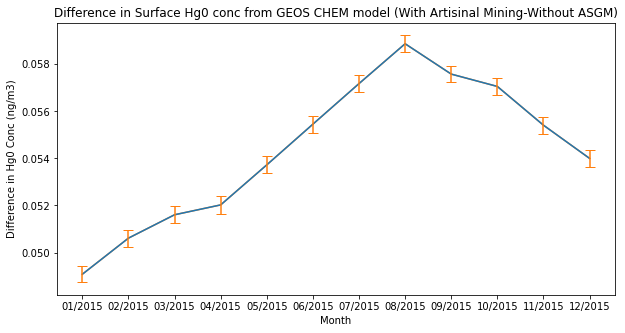

In [11]:
'''Difference in Hg0 with and without Artisinal Mining Plotplot'''
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)

#plotting, with error bars
ax.plot(months, Hg0concav['IJ-AVG-S_Hg0'])
# plt.errorbar(months, Hg0concav['Hg0conc'], yerr=stdHg0list, capsize=5.0, barsabove=True) #if you want to use standard deviation for error bars
plt.errorbar(months, Hg0concav['IJ-AVG-S_Hg0'], yerr=semHg0list, capsize=5.0, barsabove=True) #if you want to use standard error of mean for error bars
plt.title('Difference in Surface Hg0 conc from GEOS CHEM model (With Artisinal Mining-Without ASGM)')

'''showing all dates will make x axis unreadable. the following will only print every 5th date'''
every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.xlabel('Month')
plt.ylabel('Difference in Hg0 Conc (ng/m3)')

<font size="5"> Begin making colorplots here using data loaded above

In [12]:
copy=df_Asurf.copy()
df_dif=copy.drop(columns=['IJ-AVG-S_Hg0', 'IJ-AVG-S_HgP', 'IJ-AVG-S_Hg2', 'BXHGHT-S_BXHEIGHT', 'BXHGHT-S_T', 'BXHGHT-S_PMID'])
difference=[]
date=[]
subtract=df_Bsurf['IJ-AVG-S_Hg0']-df_Asurf['IJ-AVG-S_Hg0']
subtract=subtract.to_frame()
for row in subtract.itertuples():
    difference.append(row._1)
    date.append(row.Index[3])
df_dif['IJ-AVG-S_Hg0']=difference
df_dif

LON   LAT      ETAC  IJ-AVG-S_Hg0
Lon-000 Lat-000 Alt-002 time                                           
0       0       0       2015-01-01 -180.0 -89.5  0.992500      0.013571
                        2015-02-01 -180.0 -89.5  0.992500      0.016313
                        2015-03-01 -180.0 -89.5  0.992500      0.023267
                        2015-04-01 -180.0 -89.5  0.992500      0.029333
                        2015-05-01 -180.0 -89.5  0.992500      0.036753
...                                   ...   ...       ...           ...
3       5       37      2015-08-01 -172.5 -80.0  0.047641      0.000043
                        2015-09-01 -172.5 -80.0  0.047641      0.000018
                        2015-10-01 -172.5 -80.0  0.047641      0.000008
                        2015-11-01 -172.5 -80.0  0.047641      0.000003
                        2015-12-01 -172.5 -80.0  0.047641      0.000205

[157248 rows x 4 columns]

In [25]:
mydf=df_dif.reset_index()

In [27]:
updateddf=mydf.drop(['Lon-000','Lat-000','Alt-002'], axis = 1)
updateddf.set_index(['LON','LAT','time'], inplace=True)

In [28]:
updateddf

ETAC  IJ-AVG-S_Hg0
LON    LAT   time                              
-180.0 -89.5 2015-01-01  0.992500      0.013571
             2015-02-01  0.992500      0.016313
             2015-03-01  0.992500      0.023267
             2015-04-01  0.992500      0.029333
             2015-05-01  0.992500      0.036753
...                           ...           ...
-172.5 -80.0 2015-08-01  0.047641      0.000043
             2015-09-01  0.047641      0.000018
             2015-10-01  0.047641      0.000008
             2015-11-01  0.047641      0.000003
             2015-12-01  0.047641      0.000205

[157248 rows x 2 columns]

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

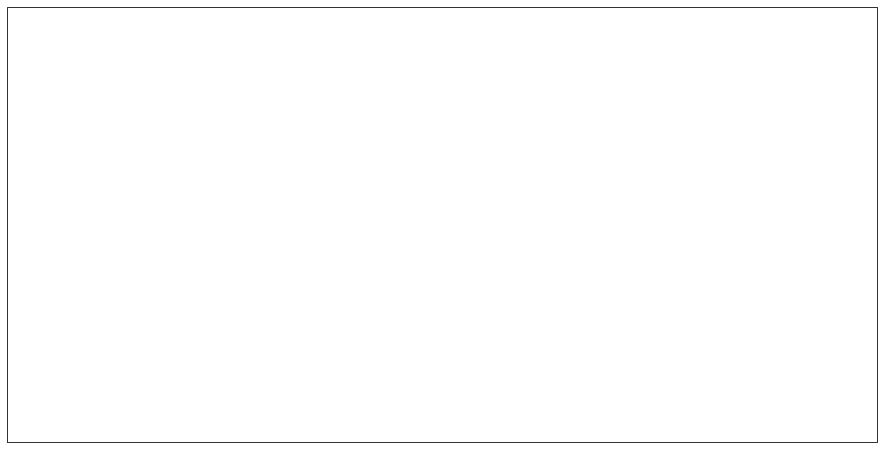

In [30]:
f, axes = plt.subplots(1, 1, figsize=[16,8],subplot_kw=dict(projection=ccrs.PlateCarree()))
#axes = axes.flatten()
                       

h = axes.pcolormesh(lon_GMA, lat_GMA, Hg0_emiss_ASGM_GMA/1000,cmap=WhGrYlRd, vmin=0, rasterized = True)

In [15]:
dsHg=df_dif.to_xarray() #change to xarray dataset so you can graph it using prev method
#coordinates got messed up so fix it
drop=dsHg.drop('Lon-000')
new=dsHg.drop('Lat-000')


In [16]:
dsHg

<xarray.Dataset>
Dimensions:       (Lon-000: 4, Lat-000: 91, Alt-002: 47, time: 12)
Coordinates:
  * Lon-000       (Lon-000) int64 0 1 2 3
  * Lat-000       (Lat-000) int64 0 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
  * Alt-002       (Alt-002) int64 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46
  * time          (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2015-12-01
Data variables:
    LON           (Lon-000, Lat-000, Alt-002, time) float32 -180.0 ... nan
    LAT           (Lon-000, Lat-000, Alt-002, time) float32 -89.5 -89.5 ... nan
    ETAC          (Lon-000, Lat-000, Alt-002, time) float32 0.9925 ... nan
    IJ-AVG-S_Hg0  (Lon-000, Lat-000, Alt-002, time) float64 0.01357 ... nan

In [ ]:
fixed_latlon=new.assign_coords({'Lon-000':np.arange(-180., 180., 2.5), 'Lat-000':np.arange(-90., 90., 1.98)})

fixed_latlon

NameError: name 'fixed_latlon' is not defined

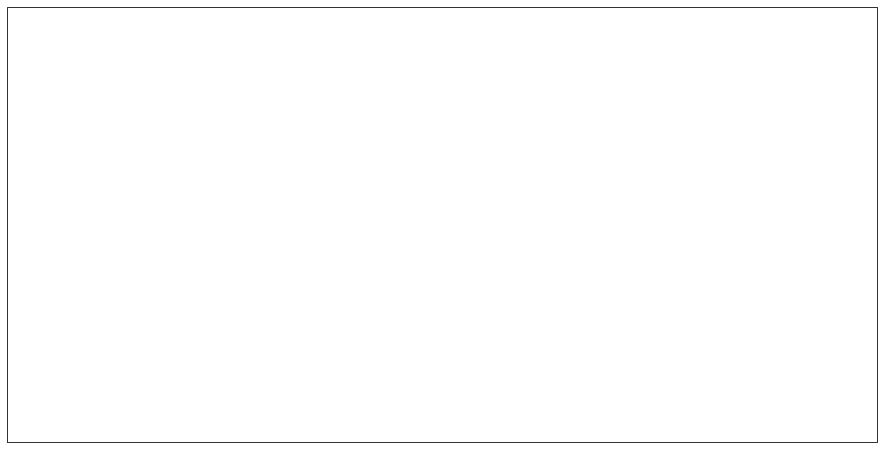

In [14]:
############## Plot time mean of Hg0 difference between Artisinal Mining and No AM ##########
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

fixed_latlon['IJ-AVG-S_Hg0'].mean(dim='time').plot(ax=ax, #set the axis
                        levels = np.arange(0, .5, .01), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':ds_a['IJ-AVG-S_Hg0'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                        cmap='hsv')  #choose color for our colorbar

ax.coastlines() #add coastlines
plt.title('Monthly Averaged Hg0 Difference (Artisinal Mining - No Artisinal Mining)', fontsize = 16); #title
av=df_d.resample('AS').mean()
print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

In [23]:
######create empty frame with coordinates already ready######
#######add percent data by creating a temporary percent dataframe, which for some reason ends up with incorrect coordinates#######

copy=df_Asurf.copy()
df_percent=copy.drop(columns=['IJ-AVG-S_Hg0', 'IJ-AVG-S_HgP', 'IJ-AVG-S_Hg2', 'BXHGHT-S_BXHEIGHT', 'BXHGHT-S_T', 'BXHGHT-S_PMID'])
percent=[]
date=[]
temp_percent=(df_Bsurf['IJ-AVG-S_Hg0']-df_Asurf['IJ-AVG-S_Hg0'])/df_Bsurf['IJ-AVG-S_Hg0']*100
temp_percent=temp_percent.to_frame()
for row in temp_percent.itertuples():
    percent.append(row._1)
    date.append(row.Index[3])
df_percent['IJ-AVG-S_Hg0']=percent
df_percent

ETAC   LAT    LON  IJ-AVG-S_Hg0
Alt-002 Lat-000 Lon-000 time                                         
0       0       0       2015-01-01  0.9925 -89.5 -180.0      4.581735
                        2015-02-01  0.9925 -89.5 -180.0      4.339969
                        2015-03-01  0.9925 -89.5 -180.0      4.279589
                        2015-04-01  0.9925 -89.5 -180.0      4.187328
                        2015-05-01  0.9925 -89.5 -180.0      4.549138
...                                    ...   ...    ...           ...
        90      143     2015-08-01  0.9925  89.5  177.5      6.474358
                        2015-09-01  0.9925  89.5  177.5      6.104205
                        2015-10-01  0.9925  89.5  177.5      6.326321
                        2015-11-01  0.9925  89.5  177.5      6.382499
                        2015-12-01  0.9925  89.5  177.5      6.801281

[157248 rows x 4 columns]

In [24]:
dsHgchange=df_percent.to_xarray() #change to xarray dataset so you can graph it using prev method

#coordinates got messed up so fix it
drop=dsHgchange.drop('Lon-000')
new=drop.drop('Lat-000')
fixed_dims=dsHgchange.assign_coords({'Lon-000':np.arange(-180., 180., 2.5), 'Lat-000':np.arange(-90., 90., 1.98)})

fixed_dims

<xarray.Dataset>
Dimensions:       (Alt-002: 1, Lat-000: 91, Lon-000: 144, time: 12)
Coordinates:
  * Alt-002       (Alt-002) int64 0
  * Lat-000       (Lat-000) float64 -90.0 -88.02 -86.04 ... 84.24 86.22 88.2
  * Lon-000       (Lon-000) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * time          (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2015-12-01
Data variables:
    ETAC          (Alt-002, Lat-000, Lon-000, time) float32 0.9924996 ... 0.9924996
    LAT           (Alt-002, Lat-000, Lon-000, time) float32 -89.5 -89.5 ... 89.5
    LON           (Alt-002, Lat-000, Lon-000, time) float32 -180.0 ... 177.5
    IJ-AVG-S_Hg0  (Alt-002, Lat-000, Lon-000, time) float64 4.582 4.34 ... 6.801

Global Average Value from Model:  7.160588191336791


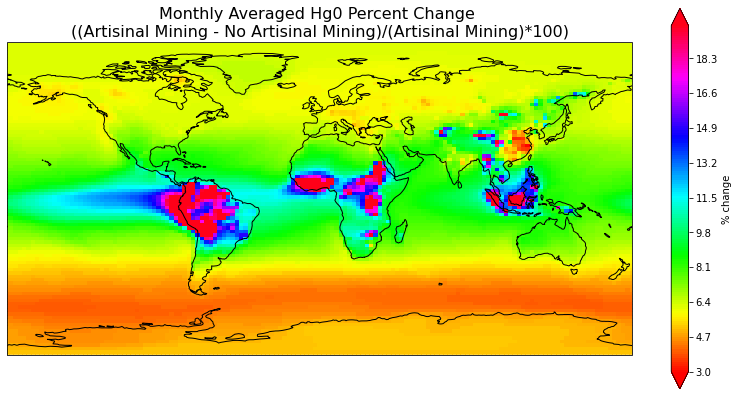

In [25]:
############## Plot time mean of Hg0 difference between Artisinal Mining and No AM ##########
fig = plt.figure(figsize=[14,7])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

fixed_dims['IJ-AVG-S_Hg0'].mean(dim='time').plot(ax=ax, #set the axis
                        levels = np.arange(3, 20, .1), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':'% change'}, #label our colorbar (use ds_a just to get units)
                        cmap='hsv')  #choose color for our colorbar

ax.coastlines() #add coastlines
plt.title('Monthly Averaged Hg0 Percent Change \n((Artisinal Mining - No Artisinal Mining)/(Artisinal Mining)*100)', fontsize = 16); #title
av=df_p.resample('AS').mean()
print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

<font size="3">  1) The largest differences between Artisinal Mining and No Artisinal Mining models occur near the equator. This is shown by a significantly higher percent change and difference around 0 degrees latitude. The highest percent change show that there is about a 20% decrease in Hg0 concentrations from the base case when no artisanal mining is occuring. Percent change decreases at the more extreme latitudes (both positive and negative).The lowest percent change is in the ocean above Antarctica. The lowest percent change shows about a 3% decrease in Hg0 concentrations from the base case when no artisinal mining is occurring.
    
<font size="3">According to the scatter plot, the difference between the artisanal mining and base case increases from January and reaches a peak in August; afterwards, the differences follow a downward trend.
    
<font size="3">2) If I wanted to see the effects of artisanal mining only being able to measure Hg0, I would take measurements in the northern region of South America; however, to know how much of this Hg0 is due to artisanal mining, I would want to take measurements in the red region(regions affected little by ASGM) as well and compare. Preferrably, the red region for comparison would be at a similar latitude. Measurements should be taken for a year (or multiple full years) to account for the seasonal changes in Hg0 concentration, and I am not sure at what frequency to take the measurement (weekly, preferrably daily?).


<font size="5">  Trying to plot data from 2 months at a time to see if there are significant concentration differences in the model at some locations (preferrably in US and CA where we already have data)

In [213]:
datasets=['/net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/BASE/netcdf_output/trac.20151101.000000.nc', 
         '/net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/BASE/netcdf_output/trac.20151201.000000.nc']
asgmdatasets=['//net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/ASGM/netcdf_output/trac.20151101.000000.nc',
             '//net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/ASGM/netcdf_output/trac.20151201.000000.nc']
ds_base2=xr.open_mfdataset(datasets, preprocess=fix_ds, concat_dim=['time'], combine='by_coords')
ds_asgm2=xr.open_mfdataset(asgmdatasets, preprocess=fix_ds, concat_dim=['time'], combine='by_coords')
# ds2=xr.open_dataset('/net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/BASE/netcdf_output/trac.20150201.000000.nc')
ds_base2
ds_asgm2

<xarray.Dataset>
Dimensions:             (Alt-000: 1, Alt-001: 38, Alt-002: 47, Alt-003: 48, Lat-000: 91, Lon-000: 144, time: 2)
Coordinates:
    ETAC                (Alt-002) float32 dask.array<chunksize=(47,), meta=np.ndarray>
    ETAE                (Alt-003) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    LAT                 (Lat-000) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    LON                 (Lon-000) float32 dask.array<chunksize=(144,), meta=np.ndarray>
  * time                (time) datetime64[ns] 2015-11-01 2015-12-01
Dimensions without coordinates: Alt-000, Alt-001, Alt-002, Alt-003, Lat-000, Lon-000
Data variables:
    Ap                  (time, Alt-003) float32 dask.array<chunksize=(1, 48), meta=np.ndarray>
    Bp                  (time, Alt-003) float32 dask.array<chunksize=(1, 48), meta=np.ndarray>
    IJ-AVG-S__Hg0       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    IJ-AVG-S__Hg2       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    IJ-AVG-S__HgP       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    EW-FLX-S__Hg0       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    EW-FLX-S__Hg2       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    EW-FLX-S__HgP       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    NS-FLX-S__Hg0       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    NS-FLX-S__Hg2       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    NS-FLX-S__HgP       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    UP-FLX-S__Hg0       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    UP-FLX-S__Hg2       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    UP-FLX-S__HgP       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    WETDCV-S__Hg2       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    WETDCV-S__HgP       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    WETDLS-S__Hg2       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    WETDLS-S__HgP       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    MC-FRC-S__Hg2       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    MC-FRC-S__HgP       (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    PEDGE-S__PSURF      (time, Alt-003, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 48, 91, 144), meta=np.ndarray>
    DAO-FLDS__PREACC    (time, Alt-000, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 1, 91, 144), meta=np.ndarray>
    DAO-FLDS__PRECON    (time, Alt-000, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 1, 91, 144), meta=np.ndarray>
    DAO-3D-S__TMPU      (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    DAO-3D-S__SPHU      (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    BXHGHT-S__BXHEIGHT  (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    BXHGHT-S__AD        (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144), meta=np.ndarray>
    BXHGHT-S__AVGW      (time, Alt-002, Lat-000, Lon-000) float32 dask.array<chunksize=(1, 47, 91, 144

In [214]:
#create shortened dataset wiht only necessary info
ds_bshort=xr.Dataset()
ds_bshort['IJ-AVG-S_Hg0']=(ds_base2['IJ-AVG-S__Hg0'])
ds_bshort['BXHGHT-S_BXHEIGHT']=(ds_base2['BXHGHT-S__BXHEIGHT'])
ds_bshort['BXHGHT-S_T']=(ds_base2['BXHGHT-S__T']) #Kelvins
ds_bshort['BXHGHT-S_PMID']=(ds_base2['BXHGHT-S__PMID'])*100 #hpa to pa
ds_bshort['BXHGHT-S_PMID'].attrs['unit']='Pa'

df_b = ds_bshort.to_dataframe()
df_bsurf=df_b[:26208]

# #######changing units to ng/m3 from ppt using P/(TR)*pptv*MW #########

'''P/(TR)*ppt*MW --> Pa/(K*J/(mol*K))*ppt*g/mol --> g/m3*ppt. to get rid of ppt, multiply by 1e-12.'''
species=['IJ-AVG-S_Hg0']
df_bsurf['IJ-AVG-S_Hg0']= df_bsurf['IJ-AVG-S_Hg0']*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng

#now units are ng/m3
ds_bshort['IJ-AVG-S_Hg0'].attrs['unit']='ng/m3'
df_bsurf

<ipython-input-214-b3040e9bbb31>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bsurf['IJ-AVG-S_Hg0']= df_bsurf['IJ-AVG-S_Hg0']*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng


ETAC   LAT    LON  IJ-AVG-S_Hg0  \
Alt-002 Lat-000 Lon-000 time                                            
0       0       0       2015-11-01  0.9925 -89.5 -180.0      0.561334   
                        2015-12-01  0.9925 -89.5 -180.0      0.399321   
                1       2015-11-01  0.9925 -89.5 -177.5      0.561334   
                        2015-12-01  0.9925 -89.5 -177.5      0.399321   
                2       2015-11-01  0.9925 -89.5 -175.0      0.561334   
...                                    ...   ...    ...           ...   
        90      141     2015-12-01  0.9925  89.5  172.5      1.240376   
                142     2015-11-01  0.9925  89.5  175.0      1.195990   
                        2015-12-01  0.9925  89.5  175.0      1.240376   
                143     2015-11-01  0.9925  89.5  177.5      1.195990   
                        2015-12-01  0.9925  89.5  177.5      1.240376   

                                    BXHGHT-S_BXHEIGHT  BXHGHT-S_T  \
Alt-002 Lat-000 Lon-000 time                                        
0       0       0       2015-11-01         103.965691  235.368286   
                        2015-12-01         107.752968  243.899643   
                1       2015-11-01         103.965691  235.368286   
                        2015-12-01         107.752968  243.899643   
                2       2015-11-01         103.965691  235.368286   
...                                               ...         ...   
        90      141     2015-12-01         109.221947  246.856720   
                142     2015-11-01         111.021034  250.896500   
                        2015-12-01         109.221947  246.856720   
                143     2015-11-01         111.021034  250.896500   
                        2015-12-01         109.221947  246.856720   

                                    BXHGHT-S_PMID  
Alt-002 Lat-000 Lon-000 time                       
0       0       0       2015-11-01   67828.562500  
                        2015-12-01   68386.617188  
                1       2015-11-01   67828.562500  
                        2015-12-01   68386.617188  
                2       2015-11-01   67828.562500  
...                                           ...  
        90      141     2015-12-01  100425.359375  
                142     2015-11-01   99812.796875  
                        2015-12-01  100425.359375  
                143     2015-11-01   99812.796875  
                        2015-12-01  100425.359375  

[26208 rows x 7 columns]

In [215]:
#create shortened dataset wiht only necessary info
ds_ashort=xr.Dataset()
ds_ashort['IJ-AVG-S_Hg0']=(ds_asgm2['IJ-AVG-S__Hg0'])
ds_ashort['BXHGHT-S_BXHEIGHT']=(ds_asgm2['BXHGHT-S__BXHEIGHT'])
ds_ashort['BXHGHT-S_T']=(ds_asgm2['BXHGHT-S__T']) #Kelvins
ds_ashort['BXHGHT-S_PMID']=(ds_asgm2['BXHGHT-S__PMID'])*100 #hpa to pa
ds_ashort['BXHGHT-S_PMID'].attrs['unit']='Pa'

df_a = ds_ashort.to_dataframe()
df_asurf=df_a[:26208]

# #######changing units to ng/m3 from ppt using P/(TR)*pptv*MW #########

'''P/(TR)*ppt*MW --> Pa/(K*J/(mol*K))*ppt*g/mol --> g/m3*ppt. to get rid of ppt, multiply by 1e-12.'''
species=['IJ-AVG-S_Hg0']
df_asurf['IJ-AVG-S_Hg0']= df_asurf['IJ-AVG-S_Hg0']*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng

#now units are ng/m3
ds_ashort['IJ-AVG-S_Hg0'].attrs['unit']='ng/m3'
df_asurf

<ipython-input-215-fb5b452f5d53>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asurf['IJ-AVG-S_Hg0']= df_asurf['IJ-AVG-S_Hg0']*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng


ETAC   LAT    LON  IJ-AVG-S_Hg0  \
Alt-002 Lat-000 Lon-000 time                                            
0       0       0       2015-11-01  0.9925 -89.5 -180.0      0.527181   
                        2015-12-01  0.9925 -89.5 -180.0      0.376096   
                1       2015-11-01  0.9925 -89.5 -177.5      0.527181   
                        2015-12-01  0.9925 -89.5 -177.5      0.376096   
                2       2015-11-01  0.9925 -89.5 -175.0      0.527181   
...                                    ...   ...    ...           ...   
        90      141     2015-12-01  0.9925  89.5  172.5      1.156014   
                142     2015-11-01  0.9925  89.5  175.0      1.119655   
                        2015-12-01  0.9925  89.5  175.0      1.156014   
                143     2015-11-01  0.9925  89.5  177.5      1.119655   
                        2015-12-01  0.9925  89.5  177.5      1.156014   

                                    BXHGHT-S_BXHEIGHT  BXHGHT-S_T  \
Alt-002 Lat-000 Lon-000 time                                        
0       0       0       2015-11-01         103.965691  235.368286   
                        2015-12-01         107.752968  243.899643   
                1       2015-11-01         103.965691  235.368286   
                        2015-12-01         107.752968  243.899643   
                2       2015-11-01         103.965691  235.368286   
...                                               ...         ...   
        90      141     2015-12-01         109.221947  246.856720   
                142     2015-11-01         111.021034  250.896500   
                        2015-12-01         109.221947  246.856720   
                143     2015-11-01         111.021034  250.896500   
                        2015-12-01         109.221947  246.856720   

                                    BXHGHT-S_PMID  
Alt-002 Lat-000 Lon-000 time                       
0       0       0       2015-11-01   67828.562500  
                        2015-12-01   68386.617188  
                1       2015-11-01   67828.562500  
                        2015-12-01   68386.617188  
                2       2015-11-01   67828.562500  
...                                           ...  
        90      141     2015-12-01  100425.359375  
                142     2015-11-01   99812.796875  
                        2015-12-01  100425.359375  
                143     2015-11-01   99812.796875  
                        2015-12-01  100425.359375  

[26208 rows x 7 columns]

In [216]:
#####Creating a dataset where the IJ-AVG-S_Hg0 column is the difference between base and asgm######
copy=df_asurf.copy()
df_dif=copy.drop(columns=['IJ-AVG-S_Hg0', 'BXHGHT-S_BXHEIGHT', 'BXHGHT-S_T', 'BXHGHT-S_PMID'])
difference=[]
date=[]
subtract=df_bsurf['IJ-AVG-S_Hg0']-df_asurf['IJ-AVG-S_Hg0']
subtract=subtract.to_frame()
for row in subtract.itertuples():
    difference.append(row._1)
    date.append(row.Index[3])
df_dif['IJ-AVG-S_Hg0']=difference
df_dif

ETAC   LAT    LON  IJ-AVG-S_Hg0
Alt-002 Lat-000 Lon-000 time                                         
0       0       0       2015-11-01  0.9925 -89.5 -180.0      0.034153
                        2015-12-01  0.9925 -89.5 -180.0      0.023226
                1       2015-11-01  0.9925 -89.5 -177.5      0.034153
                        2015-12-01  0.9925 -89.5 -177.5      0.023226
                2       2015-11-01  0.9925 -89.5 -175.0      0.034153
...                                    ...   ...    ...           ...
        90      141     2015-12-01  0.9925  89.5  172.5      0.084361
                142     2015-11-01  0.9925  89.5  175.0      0.076334
                        2015-12-01  0.9925  89.5  175.0      0.084361
                143     2015-11-01  0.9925  89.5  177.5      0.076334
                        2015-12-01  0.9925  89.5  177.5      0.084361

[26208 rows x 4 columns]

In [217]:
two_months=df_dif.to_xarray() #change to xarray dataset so you can graph it using prev method

#coordinates got messed up so fix it
drop=two_months.drop('Lon-000')
new=drop.drop('Lat-000')
fixed_dims=new.assign_coords({'Lon-000':np.arange(-180., 180., 2.5), 'Lat-000':np.arange(-90., 90., 1.98)})

fixed_dims

<xarray.Dataset>
Dimensions:       (Alt-002: 1, Lat-000: 91, Lon-000: 144, time: 2)
Coordinates:
  * Alt-002       (Alt-002) int64 0
  * time          (time) datetime64[ns] 2015-11-01 2015-12-01
  * Lon-000       (Lon-000) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * Lat-000       (Lat-000) float64 -90.0 -88.02 -86.04 ... 84.24 86.22 88.2
Data variables:
    ETAC          (Alt-002, Lat-000, Lon-000, time) float32 0.9924996 ... 0.9924996
    LAT           (Alt-002, Lat-000, Lon-000, time) float32 -89.5 -89.5 ... 89.5
    LON           (Alt-002, Lat-000, Lon-000, time) float32 -180.0 ... 177.5
    IJ-AVG-S_Hg0  (Alt-002, Lat-000, Lon-000, time) float64 0.03415 ... 0.08436

In [218]:
months=[]
for ind in df_dif.index:
    day=ind[3].to_pydatetime()
    stringdate=day.strftime('%m/%Y')
    months.append(stringdate)
month2=months[:2]

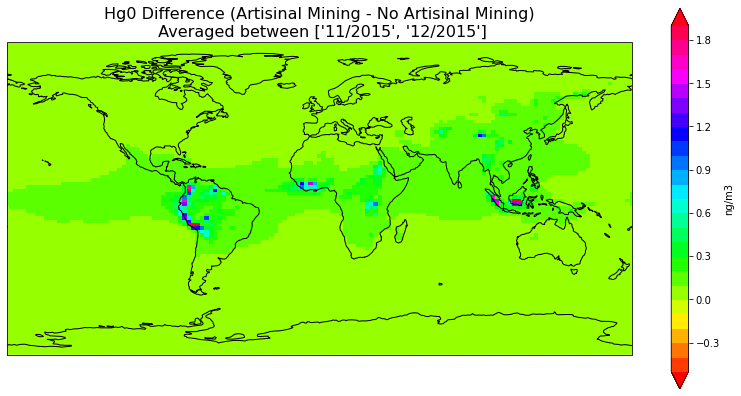

In [219]:
############## Plot time mean of Hg0 2 months ##########
fig = plt.figure(figsize=[14,7])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

fixed_dims['IJ-AVG-S_Hg0'].mean(dim='time').plot(ax=ax, #set the axis
                        levels = np.arange(-.5, 2, .1), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':'ng/m3'}, #label our colorbar (use ds_a just to get units)
                        cmap='hsv')  #choose color for our colorbar

ax.coastlines() #add coastlines
plt.title('Hg0 Difference (Artisinal Mining - No Artisinal Mining)\n Averaged between ' + str(month2), fontsize = 16); #title
# av=df_p.resample('AS').mean()
# print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

<font size='5'> LOG:
 
    20150101-20150201 = minimal difference detected in US/Canada
    20150201-20150301 = minimal difference detected in US/Canada
    20150301-20150401 = minimal difference detected in US/Canada
    20150401-20150501 = minimal difference detected in US/Canada
    20150501-20150601 = slight difference detected in US/Canada (near Fl/TX)
    20150601-20150701 = slight difference detected in US/Canada (near Fl/TX) (most change)
    20150701-20150801 = slight difference detected in US/Canada (near Fl/TX) (no change)
    20150801-20150901 = less in South and Fl now, difference in TX still detected
    20150901-20151001 = less in South, none in Fl, still TX
    20151001-20151101 = minimal difference detected in US/Canada
    20151101-20151201 = minimal difference detected in US/Canada

<font size='5'> Find data in TX, FL or other Southern states in 6-7 of 2015
    
    